In [1]:
import jax 
from jax import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import grad, jit, vmap
import jax.scipy as jsp 

import drpangloss
# from drpangloss.oifits_implaneia import load_oifits, cp_indices
from drpangloss.models import BinaryModelAngular, BinaryModelCartesian, OIData

import zodiax as zx
import equinox as eqx

import pyoifits as oifits

from functools import partial
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
fname = "alfPic_PIONIER.fits"
ddir = "../data/"

data = oifits.open(ddir+fname)
oidata = OIData(data)

In [124]:
init_values = [-76.0532, -26.3609, 0.03]
params = ["dra", "ddec", "flux"]
param_dict = dict(zip(params, init_values))
model_data = oidata.model(BinaryModelCartesian(**param_dict))

In [172]:
from drpangloss.grid_fit import likelihood_grid
samples_dict = {
    "dra":  jnp.linspace(200., -200., 210), # left is more RA 
    "ddec": jnp.linspace(-200., 200., 120), # up is more dec
    "flux": 10.**jnp.linspace(-2, 0, 50)}

loglike_im = likelihood_grid(oidata, BinaryModelCartesian, samples_dict) # calculate once to jit

In [173]:
%%time
loglike_im = likelihood_grid(oidata, BinaryModelCartesian, samples_dict)

CPU times: user 5.3 s, sys: 16.9 ms, total: 5.31 s
Wall time: 820 ms


In [179]:
loglike_im.max(axis=2).T.shape

(120, 210)

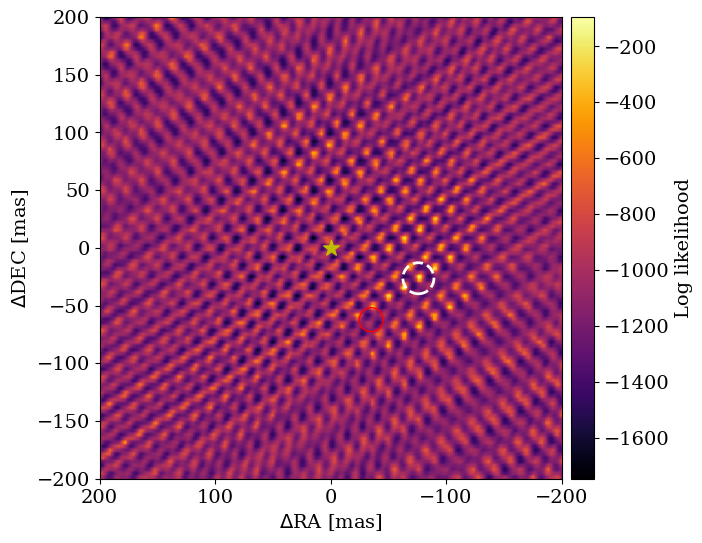

In [178]:
from drpangloss.plotting import plot_likelihood_grid
plot_likelihood_grid(loglike_im.max(axis=2).T, samples_dict, truths=init_values)
i, j, k = jnp.unravel_index(jnp.argmax(loglike_im, axis=None), loglike_im.shape)
plt.scatter(samples_dict["dra"][i], samples_dict["ddec"][j], edgecolor="r", marker="o", s=300, facecolors='none')

In [175]:
loglike_im[i,j,k]

Array(-94.19014273, dtype=float64)

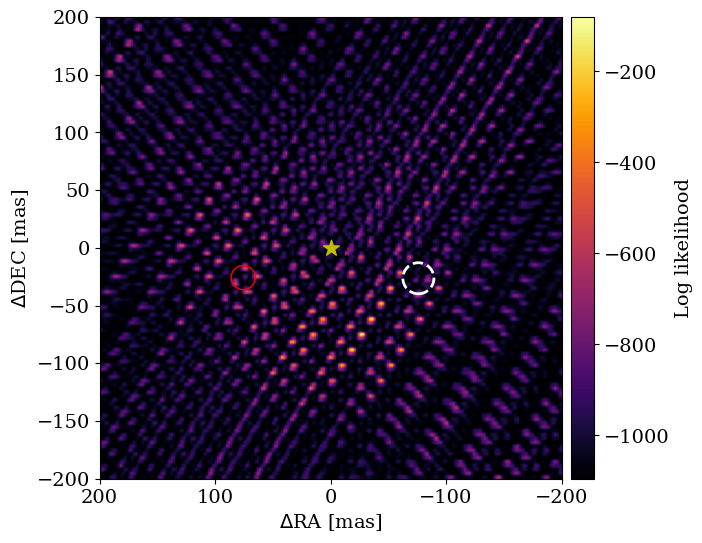

In [193]:
import matplotlib
from drpangloss.grid_fit import optimized_likelihood_grid
loglike_opt = optimized_likelihood_grid(oidata, BinaryModelCartesian, samples_dict).T
plot_likelihood_grid(loglike_opt.T, samples_dict, truths=init_values)
i, j = jnp.unravel_index(jnp.argmax(loglike_opt, axis=None), loglike_opt.shape)
plt.scatter(-samples_dict["ddec"][j],samples_dict["dra"][i], edgecolor="r", marker="o", s=300, facecolors='none')

In [188]:
samples_dict["ddec"][-j]

Array(78.99159664, dtype=float64)

In [189]:
samples_dict["dra"][-i]

Array(23.92344498, dtype=float64)

In [170]:
loglike_opt[i,j]

Array(-65.66791108, dtype=float64)

In [171]:
samples_dict["dra"][i], samples_dict["ddec"][j]

(Array(-25.83732057, dtype=float64), Array(-75.79908676, dtype=float64))

In [152]:
samples_dict["dra"][i], samples_dict["ddec"][j]

(Array(-25.83732057, dtype=float64), Array(-75.79908676, dtype=float64))

In [150]:
loglike_opt[i,j]

Array(-65.66791108, dtype=float64)

In [122]:
loglike_opt[i,j]

Array(-91.20945312, dtype=float64)

In [40]:
from drpangloss.grid_fit import optimized_contrast_grid
optimized = optimized_contrast_grid(oidata, BinaryModelCartesian, samples_dict)

In [116]:
optimized.shape

(120, 110)

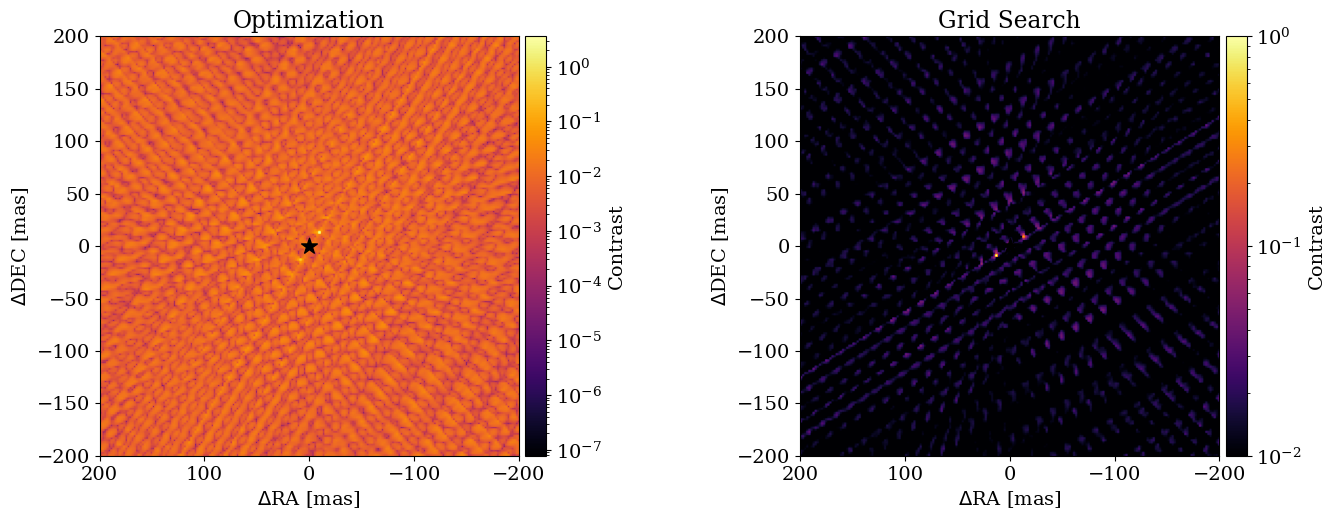

In [38]:
from drpangloss.plotting import plot_optimized_and_grid
plot_optimized_and_grid(loglike_im, abs(optimized), samples_dict)

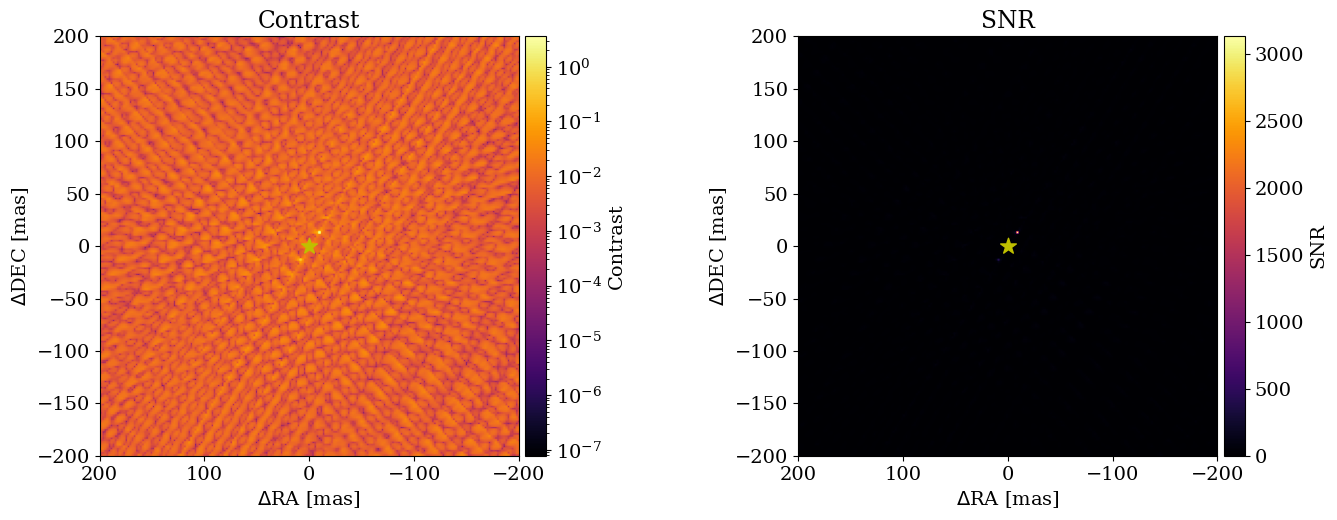

In [40]:
from drpangloss.grid_fit import laplace_contrast_uncertainty_grid
from drpangloss.plotting import plot_optimized_and_sigma
laplace_sigma_grid = laplace_contrast_uncertainty_grid(best_contrast_indices, oidata, BinaryModelCartesian, samples_dict)
plot_optimized_and_sigma(abs(optimized), laplace_sigma_grid, samples_dict,snr=True)

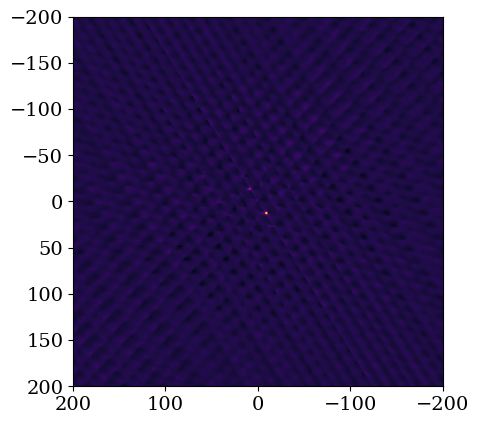

In [49]:
plt.imshow(optimized/laplace_sigma_grid,cmap='inferno', norm = matplotlib.colors.PowerNorm(0.5),
                        extent = [samples_dict["dra"].max(), samples_dict["dra"].min(), # this may seem weird, but left is more RA and up is more Dec
                        samples_dict["ddec"].max(), samples_dict["ddec"].min()])

In [70]:
i, j = jnp.unravel_index(jnp.argmax(loglike_opt, axis=None), loglike_opt.shape)
best_ra_opt, best_dec_opt = samples_dict["dra"][j], samples_dict["ddec"][i]

In [71]:
best_ra_opt, best_dec_opt

(Array(-34.86238532, dtype=float64), Array(-62.18487395, dtype=float64))

In [72]:
print(jnp.any(jnp.isnan(optimized)))

False


In [73]:
i, j, k = jnp.unravel_index(jnp.argmax(loglike_im, axis=None), loglike_im.shape)
best_ra, best_dec, best_flux = samples_dict["dra"][i], samples_dict["ddec"][j], samples_dict["flux"][k]

In [74]:
print(best_ra, best_dec, best_flux)

-89.90825688073397 -18.4873949579832 0.03366136964268266


In [75]:
i, j = jnp.unravel_index(jnp.argmax(optimized, axis=None), optimized.shape)
best_ra_opt, best_dec_opt = samples_dict["dra"][i], samples_dict["ddec"][j]

In [76]:
best_ra_opt, best_dec_opt

(Array(-20.18348624, dtype=float64), Array(-15.12605042, dtype=float64))

(0.0, 1.1)

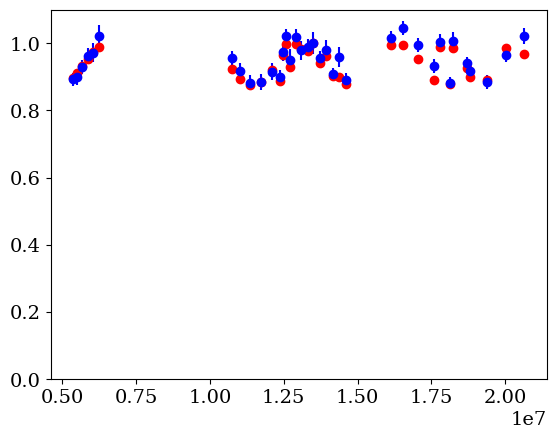

In [77]:
init_values = [best_ra, best_dec, best_flux]
params = ["dra", "ddec", "flux"]
param_dict = dict(zip(params, init_values))
model_data = oidata.model(BinaryModelCartesian(**param_dict))
data, errors = oidata.flatten_data()
x = jnp.concatenate(jnp.sqrt(oidata.u**2+oidata.v**2)[:,jnp.newaxis]/oidata.wavel, axis=0)
plt.errorbar(x, jnp.concatenate(data[0:6,:], axis=0), yerr=jnp.concatenate(errors[0:6,:], axis=0), fmt='bo', label="Data")
plt.plot(x, jnp.concatenate(model_data[0:6,], axis=0), 'ro', label="Model")
plt.ylim(0,1.1)

In [106]:
fit_values = [best_ra_opt,best_dec_opt,0.030]
params = ["dra", "ddec", "flux"]
param_dict = dict(zip(params, fit_values))
model_data = oidata.model(BinaryModelCartesian(**param_dict))
data, errors = oidata.flatten_data()

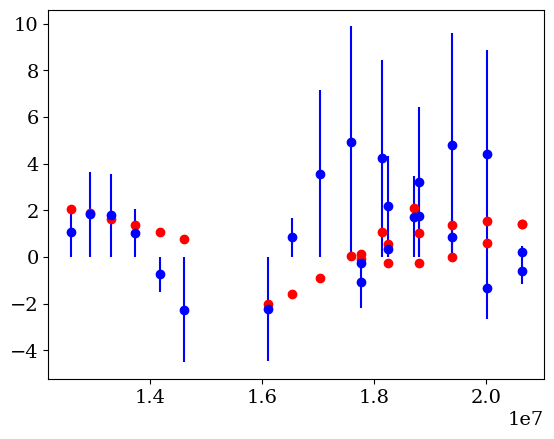

In [115]:
cp_x = jnp.concatenate(jnp.max(jnp.array([jnp.sqrt((oidata.u**2+oidata.v**2))[oidata.i_cps1],
               jnp.sqrt((oidata.u**2+oidata.v**2))[oidata.i_cps2],
               jnp.sqrt((oidata.u**2+oidata.v**2))[oidata.i_cps3]]), axis=0)[:,jnp.newaxis] / oidata.wavel, axis=0)
data, errors = oidata.flatten_data()
cp_data = data[6:,:]
model_cp_data = model_data[6:,:]
plt.errorbar(cp_x, jnp.concatenate(cp_data, axis=0), yerr=jnp.concatenate(cp_data, axis=0), fmt='bo', label="Data")
plt.plot(cp_x, jnp.concatenate(model_cp_data, axis=0), 'ro', label="Model")

(0.0, 1.1)

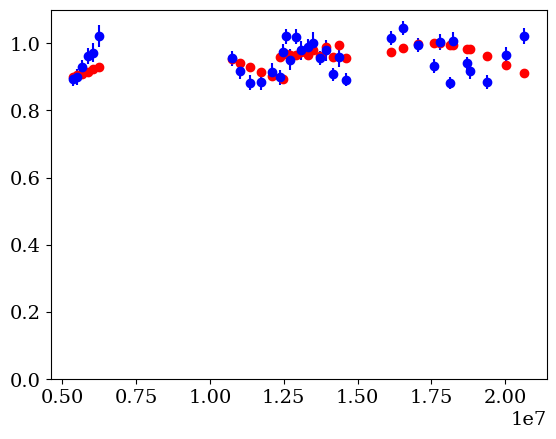

In [91]:

x = jnp.concatenate(jnp.sqrt(oidata.u**2+oidata.v**2)[:,jnp.newaxis]/oidata.wavel, axis=0)
plt.errorbar(x, jnp.concatenate(data[0:6,:], axis=0), yerr=jnp.concatenate(errors[0:6,:], axis=0), fmt='bo', label="Data")
plt.plot(x, jnp.concatenate(model_data[0:6,], axis=0), 'ro', label="Model")
plt.ylim(0,1.1)